In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../../../astro_codes/')

In [3]:
gz_data = Table.read('../matched_fits/gz_data.fits')
samples = Table.read('../matched_fits/samples.fits')

In [4]:
import scipy.stats.distributions as dist
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def get_tables_with_errors(table,normalise='fraction',error=True,column_totals=None):
    
    '''
    --- Method for calculating the 'counting' errors for individual columns
    of a table---
    
    Inputs:
    -------
    table: set of values to input.
    
    normalise: if 'fraction', all values add to 1. If 'percent' all values add to 100.
    Else, raw values will be used.
    
    error: if True, then the tables with low/high fractions will be the errors;
    if False, then they will correspond to fractions. (eg. 0.75+/-0.05 will return 
    0.7 and 0.8 if False, or 0.05 and 0.05 if True).
    
    column_totals: if None, then the column total is the sum of that column. 
    
    Outputs:
    --------
    fracs: table of fractions/ numbers (with same shape as table. If normalise isn't 
    'percent' or 'fraction',fracs will be the same as Table)
    
    fracs_low, fracs_high: exactly the same format as fracs/table, but with corresponding
    error values.
    '''
    
    fracs_low = Table()
    fracs = Table()
    fracs_high = Table()
    
    for i,c in enumerate(table.colnames):
        column = table[c]
        if column_totals == None:
            column_total = np.sum(column)
        else:
            column_total = column_totals[i]
        f = column/column_total
        f_low, f_high = get_fractional_errors(column,column_total)
        if error:
            f_low = f-f_low
            f_high = f_high-f
        if normalise == 'percent':
            f, f_low, f_high = [f*100,f_low*100,f_high*100]
        elif normalise == 'fraction':
            f, f_low, f_high = [f,f_low,f_high]
        else:
            f, f_low, f_high = [f*column_total,f_low*column_total,f_high*column_total]
        
        fracs_low[c] = f_low
        fracs[c] = f
        fracs_high[c] = f_high
    
    return fracs, fracs_low, fracs_high


def comparison_line_plot(table,labels,colors,markersize=6,markers=['o'],linewidths=[2],
                         normalise='percent',column_totals=None,right_space=2,ylabel='$\%$',
                         legend=False,joinwidth=0):


    column_labels = table.colnames
    N_columns = len(column_labels) # 'columns' = number of bar 'groups'
    
    column_centres = [j+0.5 for j in range(N_columns)]
    N_class = len(table)
    
    fracs, fracs_low, fracs_high = get_tables_with_errors(table,normalise,error=True,
                                                          column_totals=column_totals)
    
    for n in range(N_class):
        
        linewidth = linewidths[n]
        color = colors[n]
        marker = markers[n]
        label = labels[n]
        class_f = [fracs[c][n] for c in column_labels]
        class_low_error = [fracs_low[c][n] for c in column_labels]
        class_high_error = [fracs_high[c][n] for c in column_labels]

        _ = plt.errorbar(column_centres,class_f, yerr=[class_low_error,class_high_error]
                         ,markersize=markersize,linewidth=joinwidth,marker=marker,
                         ecolor=color,capsize=4,elinewidth=linewidth,capthick=linewidth,
                         label=label,color=color)
    if legend is True:
        plt.legend(fontsize=15)
    plt.xlim(column_centres[0]-1,column_centres[-1]+right_space)
    plt.xticks(column_centres,column_labels)
    plt.ylabel(ylabel)
    
    return fracs, fracs_low, fracs_high

In [5]:
bar_fractions = Table()
column_totals = []
column_labels = ['1','2','3','4','5']

in_ml = samples['in_mass_limit']
in_spiral = (samples['axial_ok']) & (samples['in_spiral'])
barred = gz_data['t03_bar_a06_bar_debiased_rh'] > gz_data['t03_bar_a07_no_bar_debiased_rh']

for m in range(5):
    
    in_m = (in_ml) & (in_spiral) & (samples['m'] == m)
    N_total = np.sum(in_m)
    N_barred = np.sum(barred[in_m])
    bar_fractions[column_labels[m]] = [N_barred]
    column_totals.append(N_total)
    
samples['barred'] = barred
samples.write('../matched_fits/samples.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


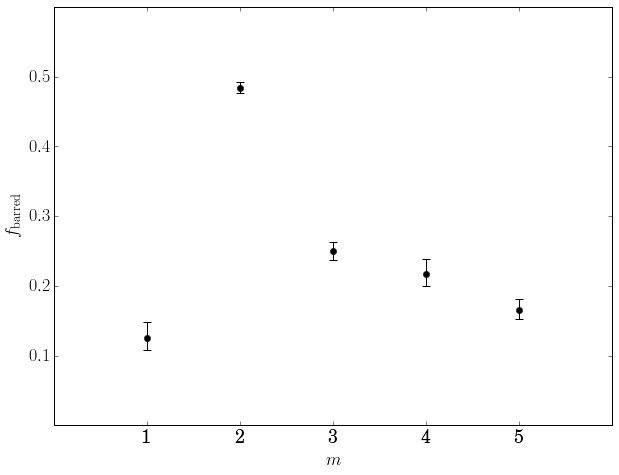

In [6]:
fig = plt.figure(figsize=(10,7.5))

_ = comparison_line_plot(bar_fractions,labels=['aaa'],colors=['k'],column_totals=column_totals,
                         normalise='fraction',ylabel='$f_\mathrm{barred}$',right_space=1,linewidths=[1])
plt.ylim(0,0.6)
plt.xlabel('$m$')

#plt.savefig('../output_figures/f_barred.pdf')

In [7]:
bar_samples = np.empty((len(samples),4))
bar_samples[:,0] = (samples['m'] == 1) & (barred == False)
bar_samples[:,1] = (samples['m'] == 1) & (barred == True)
bar_samples[:,2] = (samples['m'] > 1) & (barred == False)
bar_samples[:,3] = (samples['m'] > 1) & (barred == True)

bar_samples = np.argmax(np.array(bar_samples).T,axis=0)
# 0: m=2, unbarred
# 1: m=2, barred
# 2: m>2, unbarred
# 3: m>2 barred

In [9]:
# Now plot the IRX-beta relationship:

chang_out = Table.read('../matched_fits/chang_out_matched.fits')
nsa_data = Table.read('../matched_fits/nsa_matched.fits')
masks = Table.read('../matched_fits/bad_flux_mask.fits')

In [104]:
from luminosities_magnitudes_and_distances import solar_to_lum, lum_to_Mag, Mag_to_lum

ok_fluxes = (masks['fuv']) & (masks['nuv']) & (masks['w4']) & (masks['w4'])

beta = ((nsa_data['M_corrected'][:,0] - nsa_data['M_corrected'][:,1]))/(2.5*math.log10(2315.66/1538.62)) - 2
l_fuv = Mag_to_lum(nsa_data['M_corrected'][:,0],1538.62)
l_22_solar = chang_out['lrest_w4']
l_22 = solar_to_lum(l_22_solar)
l_tir_solar = chang_out['ldust50_all']
l_tir = solar_to_lum(l_tir_solar)

l_tir_est_solar = 0.891*l_22_solar + 2.104
l_tir_est = solar_to_lum(l_tir_estimated_solar)
irx = np.log10(l_tir/l_fuv)
irx_est = np.log10(l_tir_est/l_fuv)

[ 0.89177726  2.10437471]


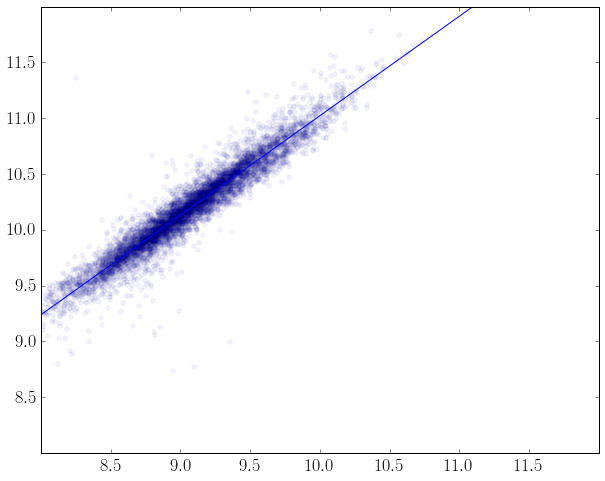

In [106]:
from scipy.optimize import curve_fit
def linear(x,m,c):
    return m*x + c

in_sample = (in_ml) & (ok_fluxes)

plt.scatter(l_22_solar[in_sample],l_tir_solar[in_sample],alpha=0.05)
p, _ = curve_fit(linear,l_22_solar[in_sample],l_tir_solar[in_sample])
plt.axis((8,12,8,12))
print(p)
xg = np.linspace(8,12,100)
yg = linear(xg,*p)
plt.plot(xg,yg)

In [107]:
def irx_beta_b12(beta):
    irx = np.log10((10**(0.396*(beta+2.046))-1)/0.373)
    return irx


def irx_beta_k04(beta):
    irx = np.log10(10**(2.1+0.85*beta)-0.95)
    return irx

beta_guide = np.linspace(-3,1,1000)
irx_k04_guide = irx_beta_k04(beta_guide)
irx_b12_guide = irx_beta_b12(beta_guide)

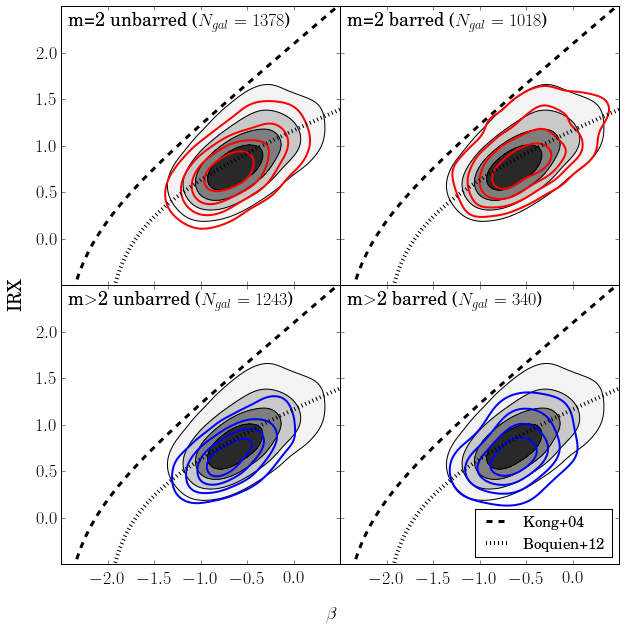

In [110]:
from contours import kde_contour

fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()

xy_range = ((-2.5,0.5,-0.5,2.5))

in_reference = (in_ml) & (ok_fluxes)
x_reference, y_reference = beta[in_reference], irx[in_reference]

figlabels = ['m=2 unbarred','m=2 barred','m$>$2 unbarred','m$>$2 barred']
colors = 'rrbb'

bandwidth=None
fill_properties = {'alpha':1}
for b in range(4):
    plt.sca(axarr[b])
    plt.plot(beta_guide,irx_k04_guide,'k--',lw=3,label='Kong+04')
    plt.plot(beta_guide,irx_b12_guide,'k:',lw=4,label='Boquien+12')
    plt.axis(xy_range)
    
    in_b = (bar_samples == b) & (in_spiral) & (in_reference)
    x_b, y_b = beta[in_b], irx[in_b]
    
    line_properties = {'linewidth':2,
                       'color':colors[b]}
    
    _, _, _, _, bandwidth = kde_contour(x_reference,y_reference,xy_range,bandwidth=bandwidth,
                                        fill=True,fill_properties=fill_properties)
    
    _ = kde_contour(x_b,y_b,xy_range,line_properties=line_properties)

    plt.text(0.025,0.975,r'{} ($N_{{gal}}={}$)'.format(figlabels[b],np.sum(in_b)),
             transform=axarr[b].transAxes,ha='left',va='top')
    
axarr[-1].legend(fontsize=15,loc='lower right')

fig.text(0.5, 0.05, r'$\beta$', ha='center')
fig.text(0.05, 0.5, 'IRX', va='center', rotation='vertical')
fig.savefig('../output_figures/irx_beta_barred_vs_unbarred.pdf')